In [1]:
from src.models.heart_module import HeartLitModule

In [2]:
ckpt_path = "/home/gsoykan/Desktop/ku/spring24_comp548_medical_imaging/hw3/unet_segmentation/logs/train/runs/2024-05-23_23-22-12/checkpoints/epoch_048.ckpt"

In [3]:
model = HeartLitModule.load_from_checkpoint(ckpt_path)
model.eval()

HeartLitModule(
  (net): UNet(
    (first_conv_block): Sequential(
      (0): Identity()
      (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (output_conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
    (down_blocks): ModuleDict(
      (0): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, ke

In [4]:
from torchmetrics.functional.classification import binary_f1_score

In [5]:
import torch
from tqdm import tqdm
from src.data.heart_datamodule import HeartDataModule

data_dir = "/home/gsoykan/Desktop/ku/spring24_comp548_medical_imaging/hw3/unet_segmentation/data"
datamodule = HeartDataModule(
    data_dir=data_dir)
datamodule.setup()
dataloader = datamodule.predict_dataloader()
f_scores = []
sample_ids = []
preds = []
with torch.inference_mode():
    for batch in tqdm(dataloader):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        img_ids = batch['img_id']
        loss, logits, y = model.model_step(batch)
        samplewise_f_scores = binary_f1_score(logits, y, multidim_average='samplewise')
        f_scores.extend(samplewise_f_scores.cpu().numpy())
        sample_ids.extend(img_ids.cpu().numpy())
        preds.extend(torch.sigmoid(logits).detach().cpu().numpy())
        del batch
        del y

  0%|          | 0/3 [00:00<?, ?it/s]/home/gsoykan/anaconda3/envs/lit-template/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


In [6]:
inference_data = list(zip(sample_ids, f_scores, preds))

In [7]:
sorted_data = sorted(inference_data, key=lambda x: x[1], reverse=True)

In [8]:
len(sorted_data)

82

In [9]:
good_1, good_2 = sorted_data[0], sorted_data[1]
acceptable_1, acceptable_2 = sorted_data[40], sorted_data[41]
bad_1, bad_2 = sorted_data[-1], sorted_data[-2]

15 67


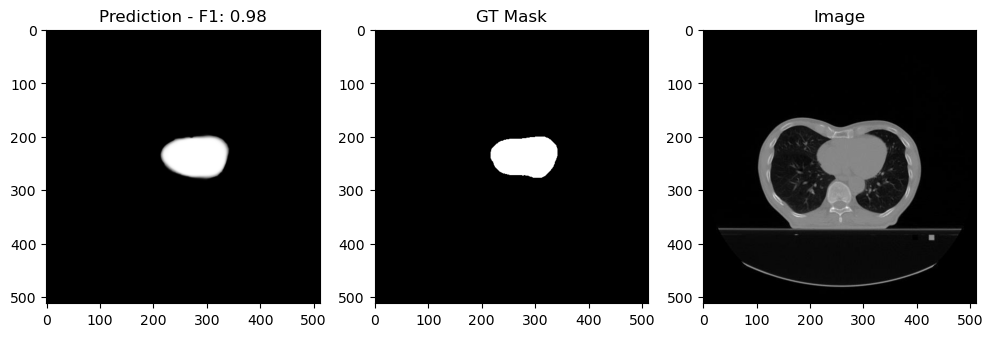

15 65


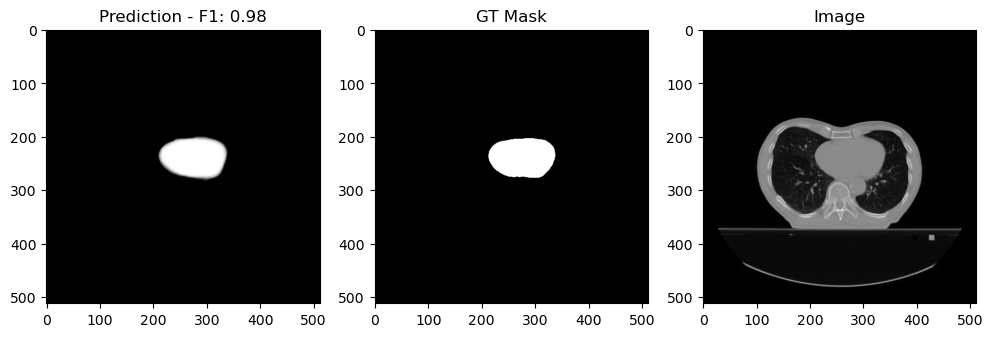

15 55


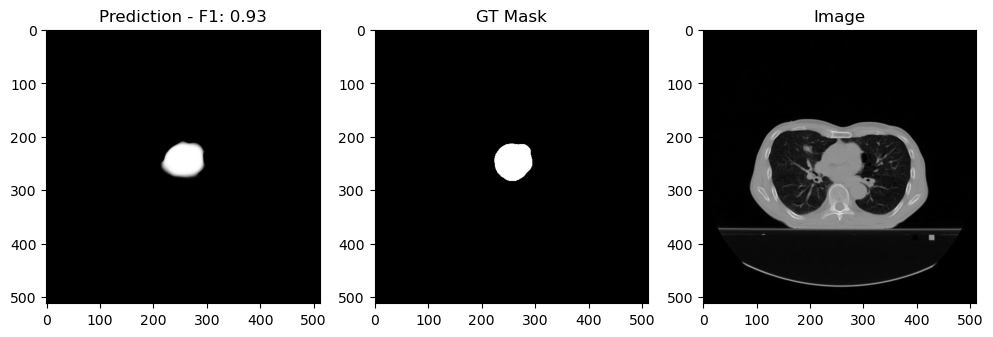

13 52


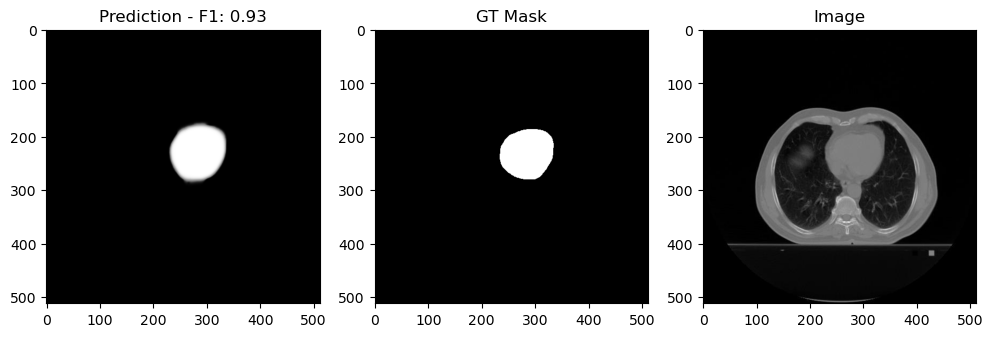

15 61


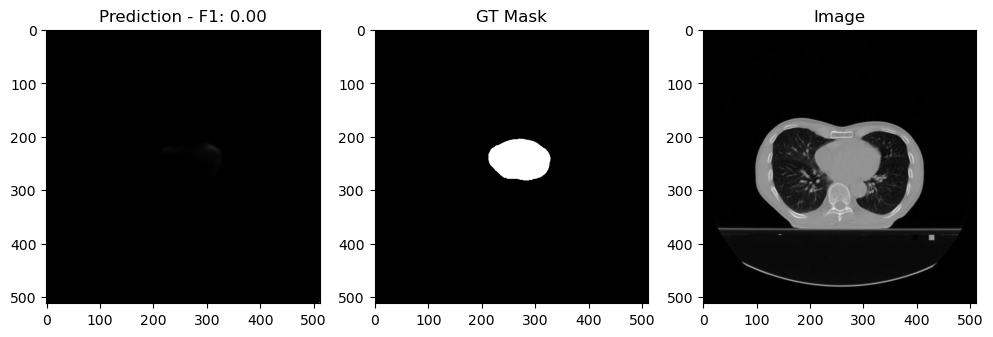

15 66


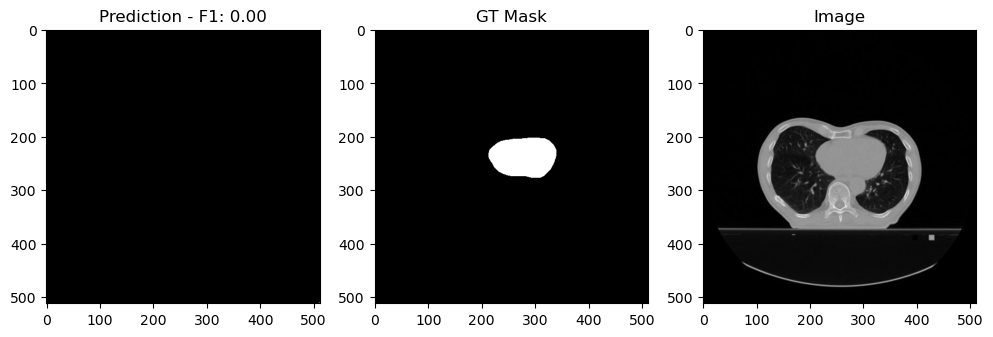

In [14]:
import os
import cv2
from matplotlib import pyplot as plt

img_root = "/home/gsoykan/Desktop/ku/spring24_comp548_medical_imaging/hw3/unet_segmentation/data/heart/images/ts"
gold_root = "/home/gsoykan/Desktop/ku/spring24_comp548_medical_imaging/hw3/unet_segmentation/data/heart/golds"

for (sample_id, f_score, pred) in [good_1, good_2, acceptable_1, acceptable_2, bad_1, bad_2]:
    major, minor = str(sample_id).split('00')
    print(major, minor)
    
     # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    # Display the pred
    ax[0].imshow(pred, cmap='gray')
    ax[0].set_title(f'Prediction - F1: {f_score:.2f}')

    # Display the mask
    gold_path = os.path.join(gold_root, f'gold_{major}_Image_{minor}.png')
    mask = cv2.imread(gold_path, cv2.IMREAD_GRAYSCALE)
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('GT Mask')
    
    # Display the image
    image_path = os.path.join(img_root, f'CT_{major}_Image_{minor}.jpg')
    base_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ax[2].imshow(base_img, cmap='gray')
    ax[2].set_title('Image')
    
    plt.savefig(f'{major}_{minor}.png')
    plt.show()
    